# Workflow Debugging

0.8785714285714286
len(y_predicted) 420
qaoa_indep_22.qasm_22  predicted:  1  should be:  0  diff:  1.1790865263496286
grover-noancilla_indep_6.qasm_6  predicted:  0  should be:  1  diff:  0.017368054277872247
qpeexact_indep_23.qasm_23  predicted:  1  should be:  0  diff:  6.345146630337695e-11
qft_indep_21.qasm_21  predicted:  1  should be:  0  diff:  0.003743265293859821
qpeinexact_indep_13.qasm_13  predicted:  1  should be:  0  diff:  2.0020096668460496e-05
qft_indep_26.qasm_26  predicted:  1  should be:  0  diff:  0.02902811630523061
qft_indep_15.qasm_15  predicted:  1  should be:  0  diff:  0.0026185363292086095
su2random_indep_18.qasm_18  predicted:  5  should be:  0  diff:  0.24193811272799692
qft_indep_19.qasm_19  predicted:  1  should be:  0  diff:  0.053738390907941636
qftentangled_indep_17.qasm_17  predicted:  1  should be:  0  diff:  0.022731331817018585
pricingcall_indep_9.qasm_9  predicted:  1  should be:  0  diff:  0.002793890591332726
qft_indep_24.qasm_24  predicted:  1

DecisionTreeClassifier(max_depth=5)

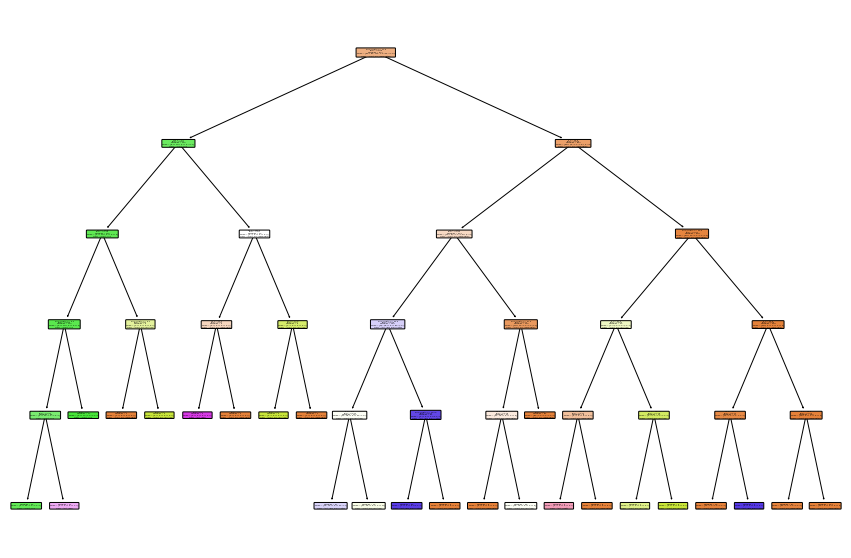

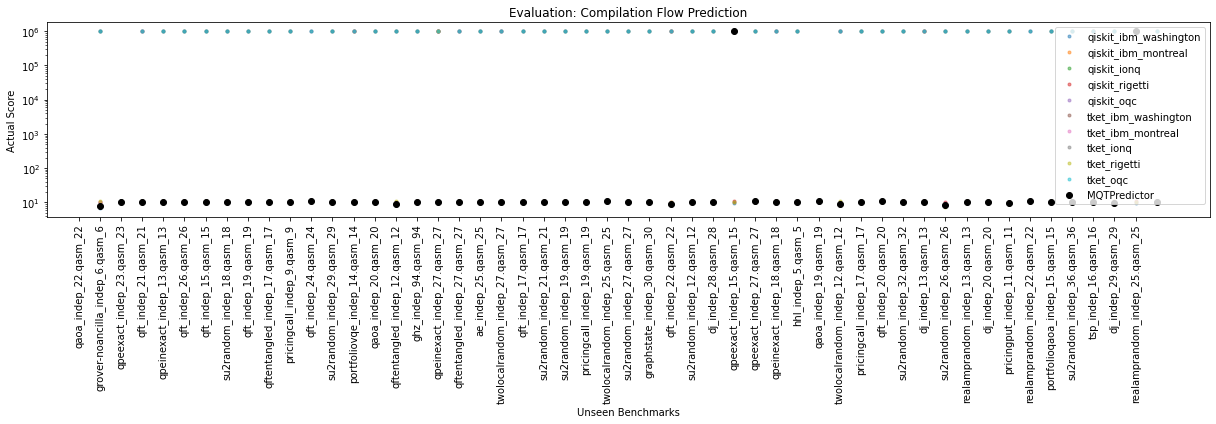

In [3]:
from predictor.driver import extract_training_data_from_json, train_neural_network
from predictor.src import utils
from predictor.driver import train_decision_tree_classifier

import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split


training_data, names_list, scores_list = extract_training_data_from_json("json_data_bigger_server.json", True)
X, y = zip(*training_data)
X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#non_zero_indices = []
#for i in range(len(X[0])):
#    if sum(X[:,i]) > 0:
#        non_zero_indices.append(i)
#X = X[:, non_zero_indices]
#openqasm_gates_list = utils.get_openqasm_gates()
#res = [openqasm_gates_list[i] for i in range(0, len(openqasm_gates_list))]
#res.append("num_qubits")
#features = np.sort(np.array(res))
#features = features[non_zero_indices]
#print(features)

scaler = preprocessing.StandardScaler().fit(X)
#X = preprocessing.normalize(X, norm='l2')
#X = scaler.transform(X)

train_decision_tree_classifier(X,y, names_list, scores_list)